This notebook outlines the process that was used to create the data and graphs for the data.

In [2]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import pymongo
import pandas as pd
from collections import defaultdict
from pprint import pprint
from datetime import datetime, timedelta
import statsmodels.formula.api as sm
import seaborn as sns
import itertools
from matplotlib.colors import LinearSegmentedColormap

# Format Crucible Data

Generates the necessary files in the "data" folder to create the visualizations.

In [3]:
# Set up database connection
# don't forget to start mongod
# sudo mongod --dbpath /Volumes/Crucible1/data
mongo = pymongo.MongoClient("localhost")
dbs = {
    2:mongo["crucible_dstu2"],
    3:mongo["crucible_stu3"]
}

In [48]:
# The scope of our analysis runs from December 2015 to May 2017.

## Run these cells once on the database before proceeding

In [49]:
# Mark DSTU2 nightlies (STU3 were already done)
for test_run in dbs[2].test_runs.find():
    if test_run["date"].hour in range(1,9):
       test_run["nightly"] = True
       dbs[2].test_runs.find_one_and_update(
            {"_id":test_run["_id"]}, 
            { "$set":{"nightly":True }}
        )

In [51]:
# Mark Duplicates in DSTU2 to avoid double counting
dbs[2].test_runs.update_many({}, {"$set":{"duplicate":False}})
dbs[3].test_runs.update_many({}, {"$set":{"duplicate":False}})
duplicates = 0
for test_run in dbs[2].test_runs.find():
    if dbs[3].test_runs.find_one({"_id": test_run["_id"]}):
        duplicates += 1
        dbs[3].test_runs.update_many({"_id":test_run["_id"]}, {"$set":{"duplicate":True}})
print(duplicates, "duplicates found")

8917 duplicates found


In [180]:
# Create Index on test_results collection to find results by server ID quickly
dbs[2].test_results.create_index("server_id")
dbs[3].test_results.create_index("server_id")
print("finished building indices")

finished building indices


## Run these cells to generate the data

In [88]:
# Returns the number of test runs that included exactly one test suite
singleton = 0
for version,db in dbs.items():
    singleton += sum([ 1 for test_run in db.test_runs.find({"nightly":False,"duplicate":False})
        if len(test_run["test_ids"])==1
    ])
print(singleton)

1970


In [89]:
# Manual Tests
manuals = []
for version,db in dbs.items():
    manuals.extend(
        [(run["date"],int(version==2), int(version==3), 1)
         for run in db.test_runs.find({"nightly": False, "duplicate":False}) ]
    )
print(len(manuals))

3253


In [91]:
# Group test runs by week and version
manual_df = pd.DataFrame(manuals, columns=["date", "dstu2", "stu3", "total"]).set_index("date")
week_df = manual_df.resample('W-SUN').sum()
print("Average Tests per Week: ",week_df["total"].mean())
week_df.to_csv("data/weekly_tests.csv")

Average Tests per Week:  42.246753246753244


In [96]:
# Load in server groupings by company
server_df = pd.read_csv("data/servers_crucible.csv")

def get_group(url):
    try:
        return server_df.loc[ server_df["url"] == url ].values[0][0]
    except Exception:
        return None

In [94]:
# Get number of suites passed by each group
suites_passed = defaultdict(lambda: set())
for version, db in dbs.items():
    for server in db.servers.find():
        group = get_group(server["url"])
        suites_passed[group].update(server.get("supported_suites", []))

In [95]:
# Get number of manual tests run by each group
group_tests = defaultdict(lambda:0)
for version,db in dbs.items():
    for test_run in db.test_runs.find({"nightly":False}):
        server = db.servers.find_one({"_id": test_run["server_id"]})
        if server:
            group = get_group(server["url"])
            group_tests[group] += 1

In [96]:
# Top Users and Performance
usage_and_performance = [(group, len(suites), group_tests[group]) for group,suites in suites_passed.items()]
usage_df = pd.DataFrame.from_records(usage_and_performance, columns=["vendor", "suites", "test_runs"])
usage_df.to_csv("data/usage_and_performance.csv")

In [81]:
# Most Frequently Run Tests
tests = defaultdict(lambda: 0)

for version, db in dbs.items():
    for test_run in db.test_runs.find({"nightly":False, "duplicate":False}):
        for test in test_run["test_ids"]:
            tests[(test, version)] += 1
            
records = [ (k[0], k[1], v) for k,v in tests.items()]
test_count_df = pd.DataFrame.from_records(records, columns=["test","version","count"])
test_count_df.to_csv("data/test_frequency.csv")

In [167]:
# Crucible Site sessions per week
sessions_df = pd.read_csv("data/site_sessions_crucible.csv")
sessions_df = sessions_df[:-1]
start_date = datetime(2016,12,1)
sessions_df["date"] = sessions_df.apply(
    lambda row: start_date + row[0] * timedelta(7), 
    axis=1
)
sessions_df.to_csv("data/sessions_crucible.csv")

In [93]:
# Define Argonauts by group name
argonauts = [
    "AEGIS",
    "Allscripts",
    "Cerner",
    "HealthIntersections",
    "Epic",
    "InterSystems",
    "NavHealth",
    "RelayHealth",
    "SMART Health IT",
    "Advisory Board Company",
    "i2b2",
    "Applied Informatics",
    "Hackensack UMC",
    "MEDITECH"
]

In [94]:
# Define Argonauts tests by ID
argonauts_suites = [
    'argonautresprint1test',
    'argonautresprint2test',
    'argonautresprint3test',
    'argonautsprint1test',
    'argonautsprint2test',
    'argonautsprint3test',
    'argonautsprint4test',
    'argonautsprint5test',
    'argonautsprint6test',
    'argonautsprint7test',
    'dataaccessframeworkprofilestest',
    'argonautproviderconnectathontest'
]

In [101]:
# Argonauts Performance on argonauts tests
argonauts_performance = {
    group:{suite:0 for suite in argonauts_suites}
    for group in argonauts
}

for version,db in dbs.items():
    for server in db.servers.find():
        group = get_group(server["url"])
        if group in argonauts:
            for suite in server["supported_suites"]:
                if suite in argonauts_suites:
                    argonauts_performance[group][suite] = 1
                    
for group, tests in argonauts_performance.items():
    tests["group"] = group

argonauts_df = pd.DataFrame.from_records(list(argonauts_performance.values()), index="group")
argonauts_df.to_csv("data/argonauts_performance_crucible.csv")

In [224]:
# Success Story
def create_success_story(group, version=3):
    # get server IDs of all servers from that group
    urls = [ server["_id"] for server in dbs[version].servers.find() if get_group(server["url"]) == group ]

    # get all related test results sorted by date
    test_results = list(dbs[version].test_results.find({"server_id":{"$in":urls}}))
    test_results = sorted( test_results, key=lambda x: x["created_at"])
    print("There are", len(test_results), "test results for", group)            

    # get all possible tests
    tests = [ [ m["id"] for m in t["methods"]] for t in dbs[version].tests.find()]
    tracker = {}
    for suite in tests:
        for test in suite:
            tracker[test] = "NA"

    date = datetime(2015,12,1)
    data = []
    test_priority = {
        "NA":0,
        "error":0.5,
        "skip":1,
        "fail":2,
        "pass":3
    }
    
    # records updates to the tracker based on the current week's results
    def record_status(date, weekly_tracker, tracker):
        for test, result in weekly_tracker.items():
            tracker[test] = result
        NA = len([i for i in tracker.items() if i[1] == "NA"])
        error = len([i for i in tracker.items() if i[1] == "error"])
        skipped = len([i for i in tracker.items() if i[1] == "skip"])
        failed = len([i for i in tracker.items() if i[1] == "fail"])
        passed = len([i for i in tracker.items() if i[1] == "pass"])
        return { 
            "date":date,
            "NA": NA,
            "skip":skipped, 
            "fail":failed, 
            "pass":passed,
            "error":error
        } 

    weekly_tracker = defaultdict(lambda: "NA")
    for test_result in test_results:
        if test_result["created_at"] > date:
            # Record status at date
            data.append(record_status(date, weekly_tracker, tracker))
            weekly_tracker = defaultdict(lambda: "NA")
            # increment date 1 week
            date = date + timedelta(days=7)

        # Update Status
        for result in test_result["result"]:
            if test_priority[result["status"]] > test_priority[weekly_tracker[result["id"]]]:
                weekly_tracker[result["id"]] = result["status"]

    data.append(record_status(date, weekly_tracker,tracker))
    tracker_df = pd.DataFrame.from_dict(data)

    # Save the results
    tracker_df.to_csv("data/" + group + "_" + str(version) + "_servers.csv")

In [233]:
group = "SRDC"
create_success_story(group, version=2)
create_success_story(group, version=3)

There are 229 test results for SRDC
There are 3366 test results for SRDC


# AEGIS Data

Some helper functions to process AEGIS data.

In [145]:
def fix_dates(df, column_name = "date"):
    df = df.dropna( subset = [column_name])
    df[column_name] = df[column_name].apply(fix_date)
    return df

def fix_date(date):
    parts = date.split("/")
    day = int(parts[1])
    month = int(parts[0])
    year = int(parts[2]) + 2000
    new_date = datetime(year, month, day)
    return str(new_date.date())

Some code to look at tests frequency in AEGIS data

In [87]:
df = pd.read_csv("touchstone_data/test_frequency_Touchstone.csv")

In [88]:
df.columns

Index(['Unnamed: 0', 'test', 'version ', 'count'], dtype='object')

In [128]:
records = df.to_dict("records")
terms = ["patient", "terminology", "connectathon", "argonaut", 
         "basicdstu2", "basicstu3","basicoperations"]
releases = ["fhir1-0","fhir1-2","fhir1-4","fhir1-6", "fhir1-8", "fhir3-0-0", "fhir3-0-1"]
counts = defaultdict(lambda : 0)
release_counts = defaultdict(lambda: 0)
version = defaultdict(lambda:0)

total = 0
for r in records:
    for term in terms:
        if term in r["test"].lower():
            counts[term] += r["count"]
    for release in releases:
        if release in r["test"].lower():
            release_counts[release] += r["count"]
    total += r["count"]
    version[r["version "]] += r["count"]
    
for term in terms:
    print(term.upper(), "TESTS:", " "*(20 - len(term)), counts[term], "\t", counts[term]*1.0/total*100,"%" )
print("-----------------------------------------------------------------------")

for term in releases:
    print(term.upper(), "TESTS:", " "*(20 - len(term)), release_counts[term], "\t", release_counts[term]*1.0/total*100,"%" )
print("-----------------------------------------------------------------------")

for v in version.keys():
    print("VERSION", v, ":", version[v])
print("-----------------------------------------------------------------------")
print("TOTAL TESTS:", " "*15, total)

PATIENT TESTS:               99848 	 18.844685352564042 %
TERMINOLOGY TESTS:           55163 	 10.411118681430677 %
CONNECTATHON TESTS:          125720 	 23.727604383907053 %
ARGONAUT TESTS:              4682 	 0.8836513182107288 %
BASICDSTU2 TESTS:            11229 	 2.1192910406211607 %
BASICSTU3 TESTS:             9295 	 1.7542800091347126 %
BASICOPERATIONS TESTS:       25085 	 4.7343855867826 %
-----------------------------------------------------------------------
FHIR1-0 TESTS:               34429 	 6.497913548628189 %
FHIR1-2 TESTS:               21052 	 3.9732224585587916 %
FHIR1-4 TESTS:               19444 	 3.669738622658994 %
FHIR1-6 TESTS:               83780 	 15.812111798311587 %
FHIR1-8 TESTS:               87862 	 16.582522879246273 %
FHIR3-0-0 TESTS:             37656 	 7.106957291444512 %
FHIR3-0-1 TESTS:             108387 	 20.456282662730942 %
-----------------------------------------------------------------------
VERSION 2 : 76066
VERSION 3 : 453781
-------------

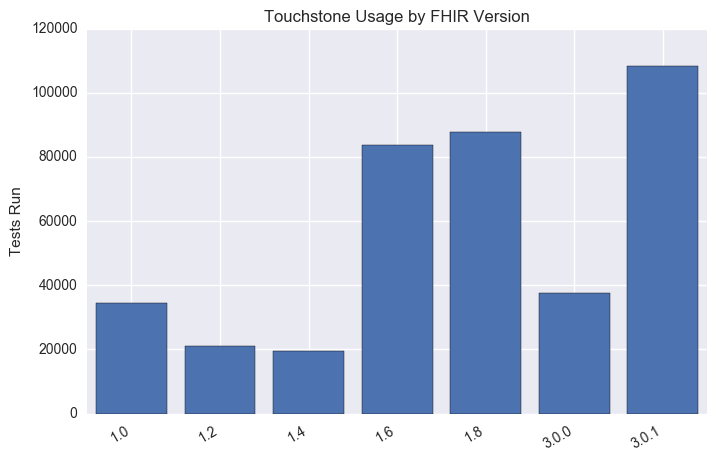

In [143]:
def bar_chart(name_map ,kv):
    ind = np.arange(len(name_map))
    width = 0.8
    rects = plt.bar(
        ind+0.1, 
        [kv[i[1]] for i in name_map],
        width,
        #color=sns.color_palette("muted")[0]
    )
  
    plt.title("Touchstone Usage by FHIR Version")
    plt.ylabel("Tests Run")
    plt.xticks(ind+0.5, [i[0] for i in name_map] )
    plt.gcf().autofmt_xdate()
    plt.show()
    
bar_chart(
    [ 
        ("1.0","fhir1-0"),
        ("1.2","fhir1-2"),
        ("1.4","fhir1-4"),
        ("1.6","fhir1-6"),
        ("1.8","fhir1-8"),
        ("3.0.0","fhir3-0-0"),
        ("3.0.1","fhir3-0-1")
    ],
    release_counts)

# Create Graphs

1. Manual tests by week
2. Compare dstu2 vs. stu3 usage.
3. Regression Results
4. Success Stories
5. Top Users and Performance
6. Most Frequently Run Tests
7. Crucible Site sessions per week
8. Argonauts Performance

## 1. Manual Tests by week

In [21]:
''' takes pandas dataframe with columns "date" and "tests" '''
def manual_tests_by_week(dataframe, date_format = "%Y-%m-%d"):
    pd.to_datetime(dataframe["date"])
    fig = plt.figure(figsize=(20,5))
    dates = [ datetime.strptime(date, date_format) for date in dataframe["date"] ]
    fig.suptitle("Test Runs Per Week")
    ax = plt.subplot()
    ax.bar(dates,dataframe["total"], width=6, color=sns.color_palette("muted")[0])
    ax.xaxis_date()
    plt.gcf().autofmt_xdate()
    plt.show()

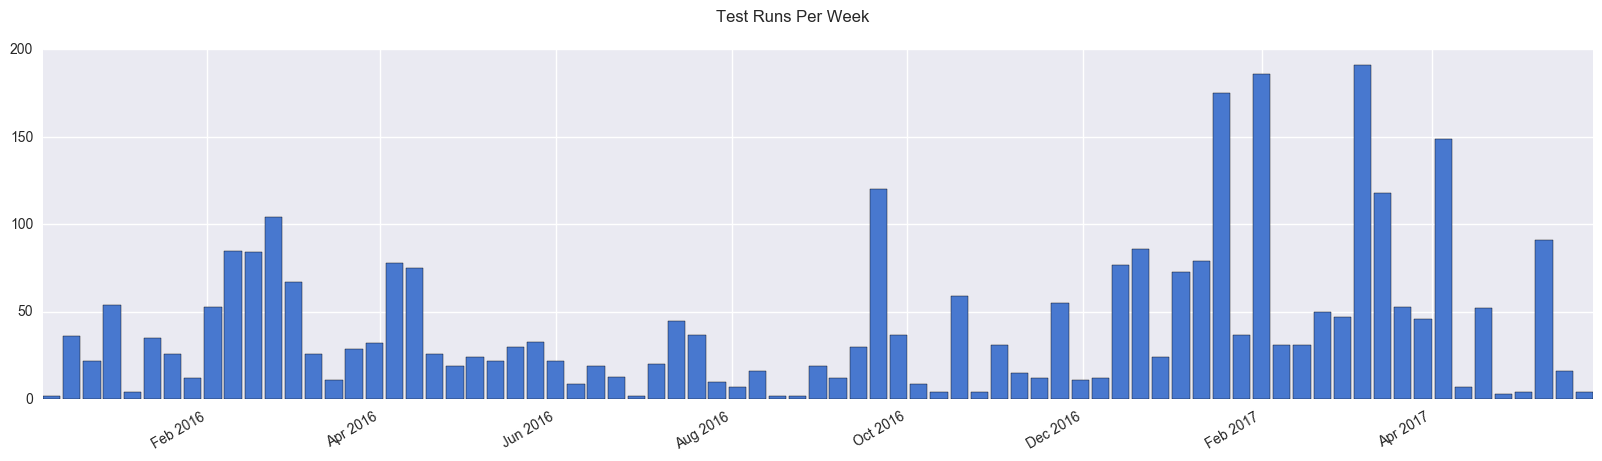

In [16]:
crucible_df = pd.read_csv("data/weekly_tests.csv")
manual_tests_by_week(crucible_df)

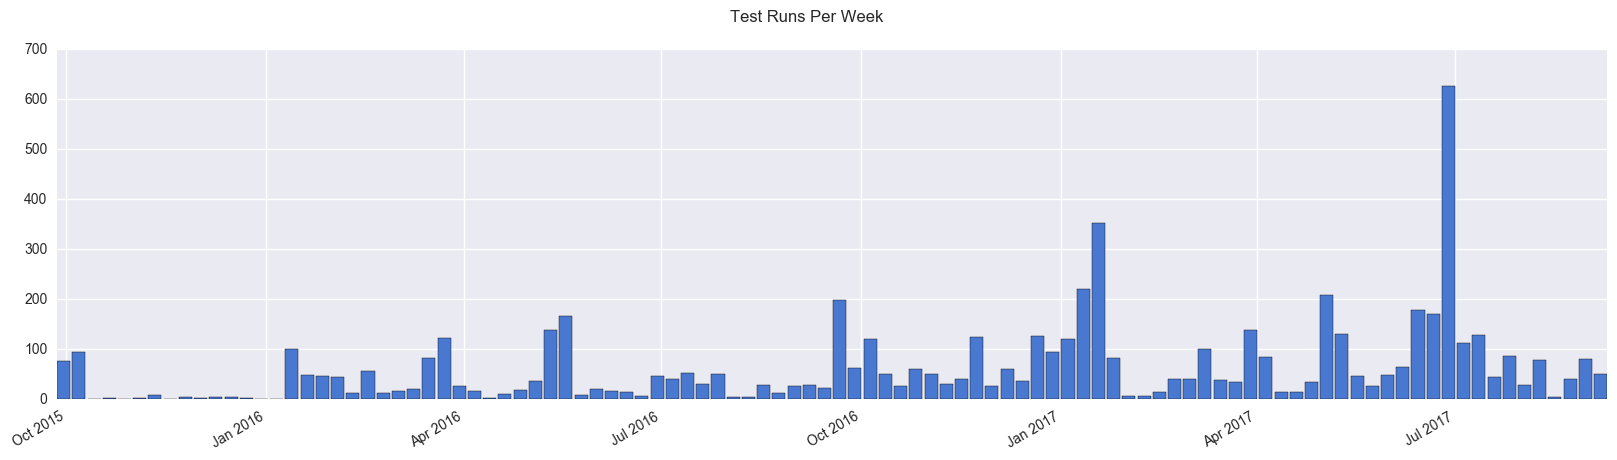

In [150]:
aegis_df = pd.read_csv("touchstone_data/Weekly Sessions - Touchstone - dstu2 vs stu3.csv")
aegis_df = fix_dates(aegis_df)
manual_tests_by_week(aegis_df)

## 2. Version Usage - dstu2 vs. stu3

In [35]:
''' takes a pandas dataframe with columns "date", "dstu2", and "stu3" '''
def version_usage_by_week(dataframe):
    pd.to_datetime(dataframe["date"])
    fig = plt.figure(figsize=(20,5))
    dates = [ datetime.strptime(date, '%Y-%m-%d') for date in dataframe["date"] ]

    fig.suptitle("Version Usage by Week")
    ax = plt.subplot()
    ax.plot(dates, dataframe["dstu2"], color=sns.color_palette("muted")[0])
    ax.plot(dates, dataframe["stu3"], color=sns.color_palette("muted")[2])
    ax.xaxis_date()
    plt.gcf().autofmt_xdate()
    plt.show()

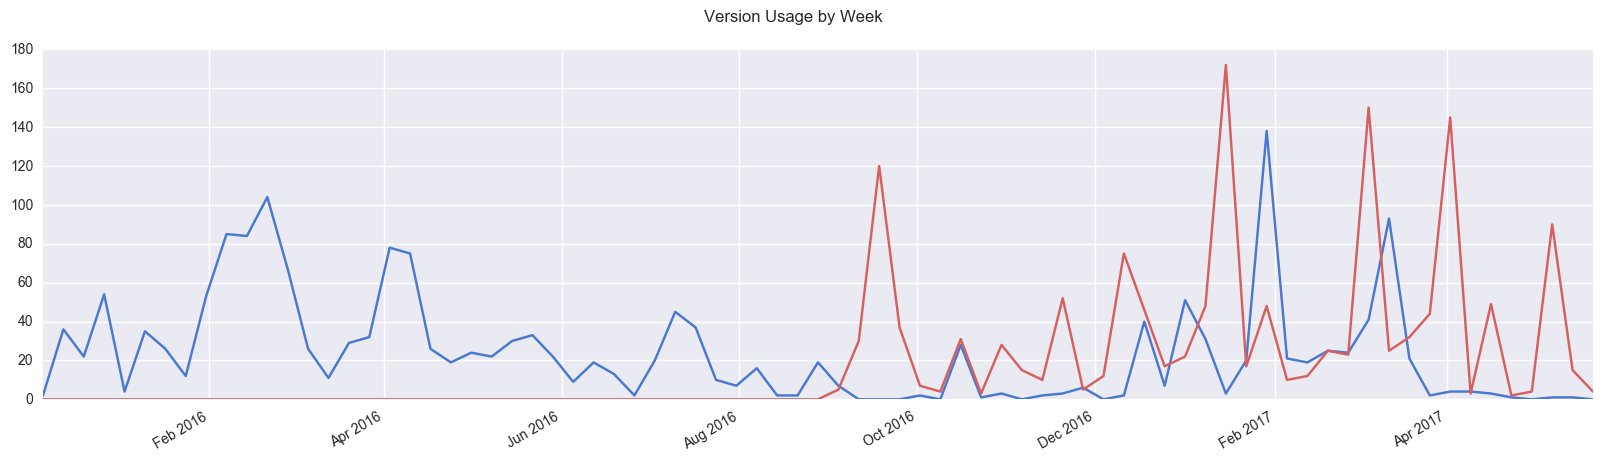

In [36]:
crucible_df = pd.read_csv("data/weekly_tests.csv")
version_usage_by_week(crucible_df)

/Users/cdowling/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


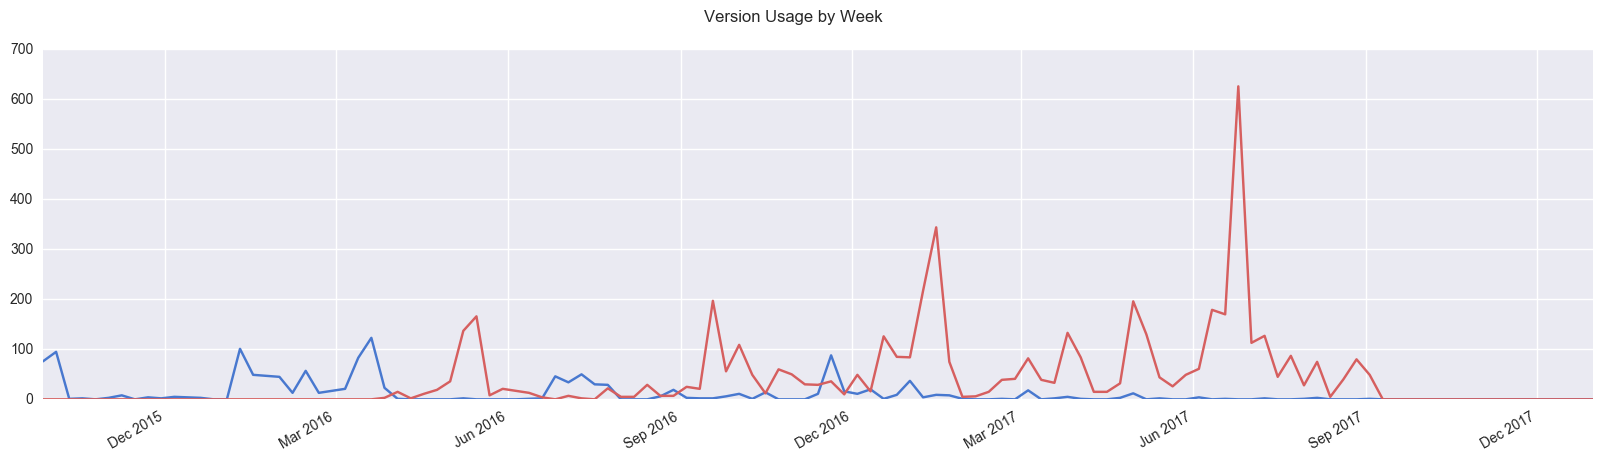

In [66]:
aegis_df = pd.read_csv("touchstone_data/Weekly Sessions - Touchstone - dstu2 vs stu3.csv")
aegis_df = fix_dates(aegis_df)
version_usage_by_week(aegis_df)

## 3. Regression - uses vs. performance

In [68]:
''' Takes a pandas dataframe with columns "suites" and "test_runs" '''
def regression_results(dataframe):
    result = sm.ols(formula="suites ~ test_runs", data=dataframe).fit()
    return result.summary()

In [69]:
crucible_df = pd.read_csv("data/usage_and_performance.csv")
regression_results(crucible_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 suites   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     40.18
Date:                Thu, 14 Sep 2017   Prob (F-statistic):           4.90e-09
Time:                        12:18:49   Log-Likelihood:                -709.42
No. Observations:                 115   AIC:                             1423.
Df Residuals:                     113   BIC:                             1428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     98.3549     12.044      8.166      0.000        74.494   122.216
test_runs      0.8084      0.128      6.339      0.000         0.556     1.061
==============================================================================
Omnibus:                       13.431   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               11.864
Skew:                           0.703   Prob(JB):                      0.00265
Kurtosis:                       2.294   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
aegis_df = pd.read_csv("touchstone_data/usage_and_performance_touchstone.csv")
regression_results(aegis_df)

/Users/cdowling/anaconda3/lib/python3.5/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 suites   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     20.49
Date:                Thu, 14 Sep 2017   Prob (F-statistic):              0.138
Time:                        12:18:50   Log-Likelihood:                -21.157
No. Observations:                   3   AIC:                             46.31
Df Residuals:                       1   BIC:                             44.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    274.2282    388.172      0.706      0.608     -4657.969  5206.425
test_runs      0.0152      0.003      4.527      0.138        -0.028     0.058
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.309
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.305
Skew:                           0.218   Prob(JB):                        0.859
Kurtosis:                       1.500   Cond. No.                     1.60e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 4. Success Stories

In [76]:
def success_graph(dataframe):
    y = np.row_stack(( 
        list(dataframe["pass"]), 
        list(dataframe["fail"]), 
        list(dataframe["error"]), 
        list(dataframe["skip"])
    ))
    #x = list(dataframe["date"])
    x = [ datetime.strptime(date, '%Y-%m-%d') for date in dataframe["date"] ]
    colors = [
        sns.color_palette("muted")[0],
        sns.color_palette("muted")[2],
        sns.color_palette("muted")[3],
        sns.color_palette("muted")[4]
    ]
    
    fig,ax = plt.subplots()
    ax.stackplot(x,y, colors=colors)
    plt.legend(["Pass","Fail","Error","Skip"], loc="upper left")
    plt.show()

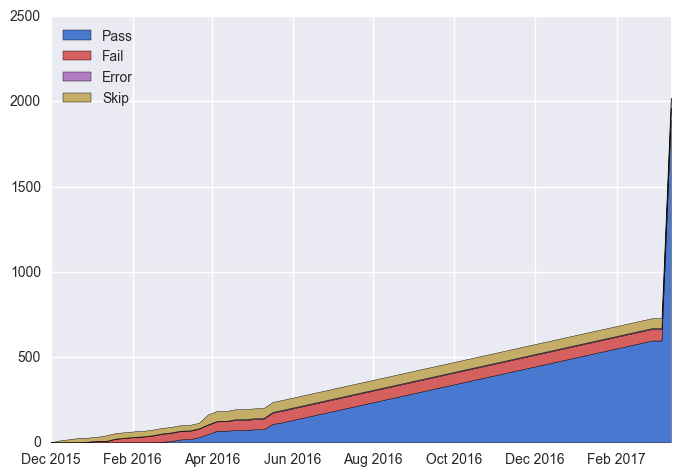

In [77]:
success_graph(pd.read_csv("data/SRDC_2_servers.csv"))

In [79]:
# NO CORRESPONDING AEGIS DATA
aegis_df = pd.read_csv("touchstone_data/")

## 5. Top Users and Performers

In [109]:
''' takes a pandas dataframe with columns "group", "test_runs", and "suites" '''
NUM = 10
def top_users_graph(dataframe):
    dataframe = dataframe.sort_values(by=["test_runs"], ascending=False)
    top_users = dataframe.head(n=NUM)
    
    ind = np.arange(NUM)
    width=0.3
    rects1 = plt.bar(
        ind+0.2, 
        list(top_users["test_runs"]), 
        width, 
        color=sns.color_palette("muted")[0]
    )
    rects2 = plt.bar(
        ind+width+0.2, 
        list(top_users["suites"]), 
        width, 
        color=sns.color_palette("muted")[2]
    )
    plt.legend((rects1[0],rects2[0]), ("Test Runs", "Suites Passed"))
    plt.title("Crucible Usage vs. Performance")
    plt.xticks(ind+0.5, list(top_users["vendor"]))
    plt.gcf().autofmt_xdate()
    plt.show()

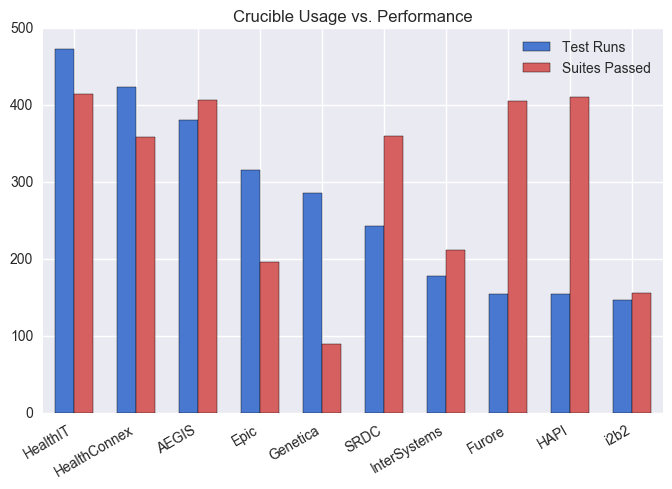

In [110]:
crucible_df = pd.read_csv("data/usage_and_performance.csv")
top_users_graph(crucible_df)

In [27]:
aegis_df = pd.read_csv("touchstone_data/usage_and_performance_touchstone.csv")

## 6. Most frequently run tests

In [81]:
''' takes a pandas dataframe with columns "test" and "count" '''
def frequent_tests(dataframe, num=10):
    tests = defaultdict(lambda:0)
    for test in dataframe.to_dict('records'):
        tests[test["test"]] += test["count"]
    sorted_tests = sorted(tests.items(), key=lambda x: x[1],reverse=True)
    top_tests = sorted_tests[0:10]
    pprint(top_tests)
    #dataframe = dataframe.sort_values("count", ascending=False)
    #top_tests = dataframe.head(num)
    #print(top_tests)
    ind = np.arange(num)
    width = 0.8
    rects = plt.bar(
        ind+0.1, 
        [i[1] for i in top_tests], #list(top_tests["count"]),
        width,
        color=sns.color_palette("muted")[0]
    )
    
    plt.title("Test Usage")
    plt.xticks(ind+0.5, [i[0] for i in top_tests] )#list(top_tests["test"]))
    plt.gcf().autofmt_xdate()
    plt.show()

[('argonautsprint1test', 858),
 ('readtest', 664),
 ('argonautsprint3test', 549),
 ('argonautsprint4test', 539),
 ('history001', 476),
 ('search001', 475),
 ('format001', 460),
 ('argonautsprint5test', 451),
 ('transactionandbatchtest', 447),
 ('resourcetest_patient', 445)]


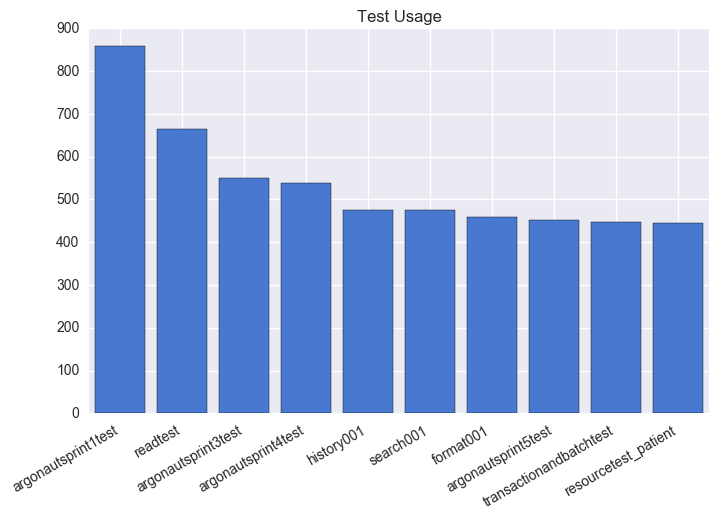

In [82]:
crucible_df = pd.read_csv("data/test_frequency.csv")
frequent_tests(crucible_df)

[('/Connectathon10/Track1-Patient/track1-patient-base-client-id-xml', 3092),
 ('/Connectathon12/Track-16-Terminology/Validate-code/Existing '
  'ValueSets/connectathon-12-track-16-ts-validate-code-existing-id',
  2698),
 ('/FHIR3-0-1-Advanced/Patient/03-create/fhir-api-stu3-patient-create-01-ok',
  2381),
 ('/Connectathon10/Track1-Patient/track1-patient-bonus-client-id-xml', 2369),
 ('/Advanced-FHIR1-8-0/Patient/03-create/fhir-api-stu3-patient-create-01-ok',
  2322),
 ('/Advanced-FHIR1-8-0/Patient/04-update/fhir-api-stu3-patient-update-04-conditional',
  1935),
 ('/Advanced-FHIR1-6-0/Patient/04-update/fhir-api-stu3-patient-update-04-conditional',
  1810),
 ('/Advanced-FHIR1-6-0/Patient/03-create/fhir-api-stu3-patient-create-01-ok',
  1802),
 ('/Connectathon10/Track1-Patient/track1-patient-base-server-id-xml', 1762),
 ('/Advanced-FHIR1-6-0/Patient/04-update/fhir-api-stu3-patient-update-01-ok',
  1718)]


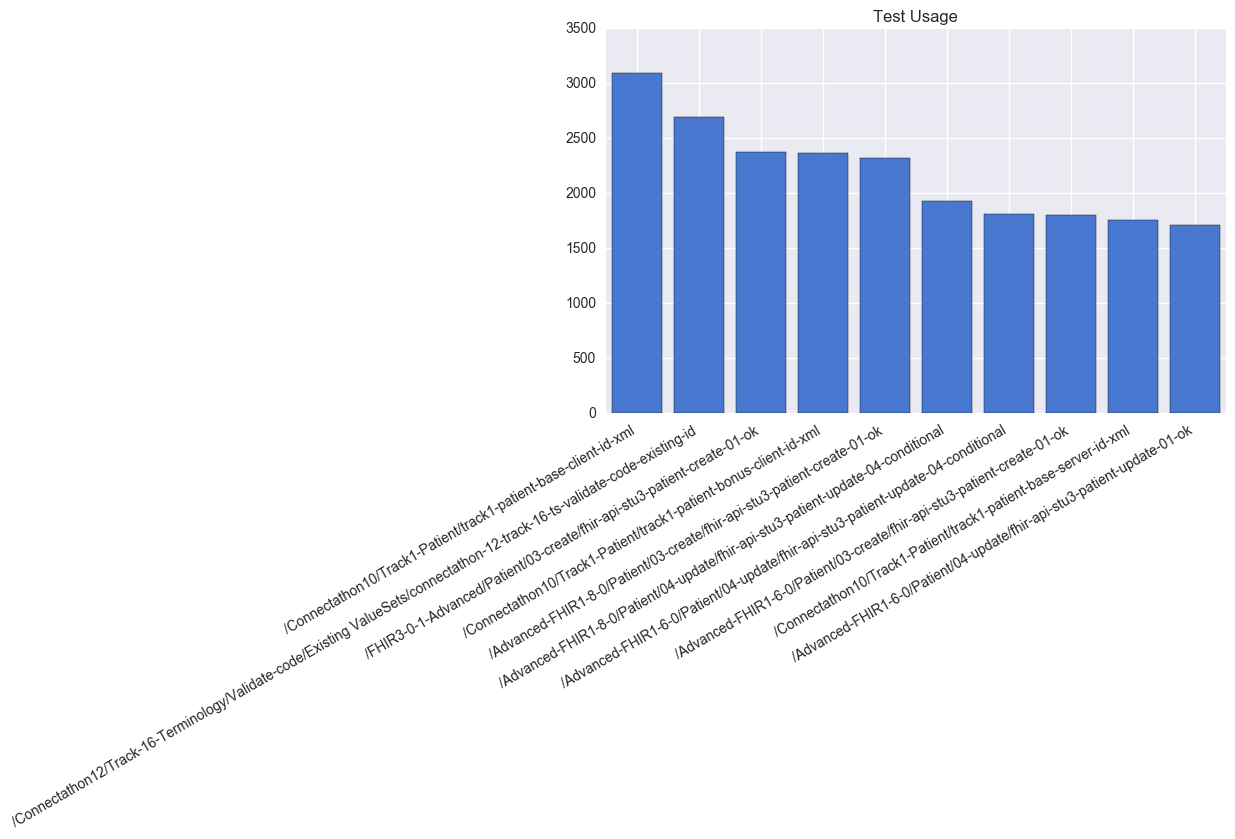

In [83]:
aegis_df = pd.read_csv("touchstone_data/test_frequency_Touchstone.csv")
frequent_tests(aegis_df)

## 7. Site Sessions

In [181]:
''' takes a pandas dataframe with columns "date" and "Sessions" '''
def site_sessions(dataframe):
    pd.to_datetime(dataframe["date"])
    fig = plt.figure(figsize=(20,5))
    dates = [ datetime.strptime(date, '%Y-%m-%d') for date in dataframe["date"] ]

    fig.suptitle("Site Sessions by Week")
    ax = plt.subplot()
    ax.plot(dates, dataframe["Sessions"], color=sns.color_palette("muted")[1])
    ax.scatter(
        dates, 
        dataframe["Sessions"], 
        color=sns.color_palette("muted")[1],
        s=50,
    )
    ax.xaxis_date()
    plt.gcf().autofmt_xdate()
    plt.show()

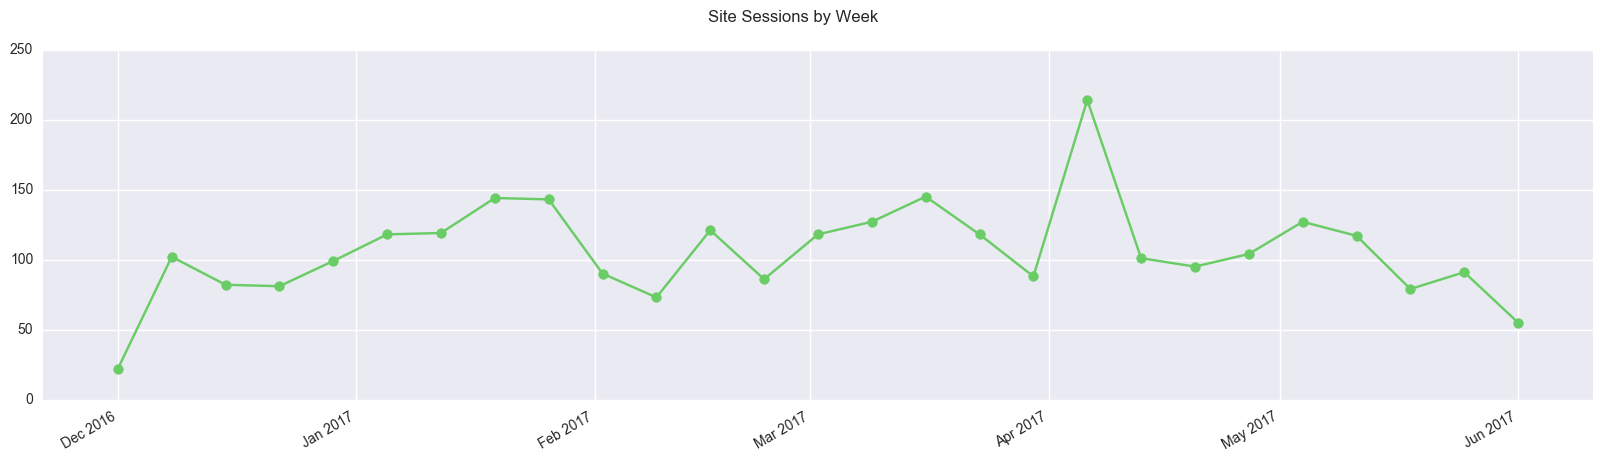

In [182]:
crucible_df = pd.read_csv("data/sessions_crucible.csv")
site_sessions(crucible_df)

In [33]:
# NO AEGIS DATA

## 8. Argonauts Performance

In [126]:
''' Takes a pandas dataframe with a "group" column 
    and one column for each test with True/False or 1/0 values '''
def argonauts_performance_table(dataframe,test_names):
    groups = list(dataframe["group"])
    del dataframe["group"]
    annotation = np.array([ 
        ["Pass" if i else "Fail" for i in row]
        for row in dataframe.values
    ])
    return sns.heatmap(
        dataframe, 
        linewidths=.5,
        cmap=LinearSegmentedColormap.from_list("pass/fail",[sns.color_palette("muted")[2],sns.color_palette("muted")[1]]),
        annot=annotation,
        fmt='',
        annot_kws={"size":"xx-small"},
        xticklabels=[test_names[t] for t in list(dataframe.columns)],
        yticklabels=groups,
        cbar=False
    )

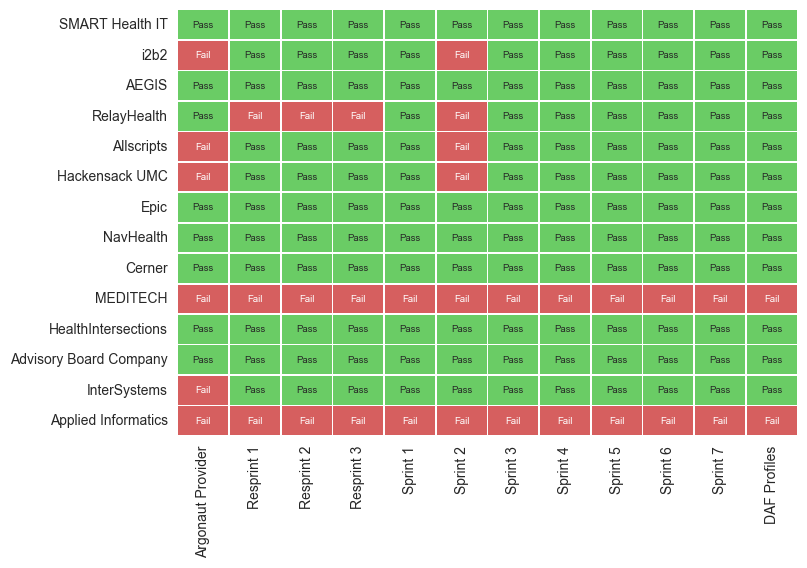

In [127]:
crucible_df = pd.read_csv("data/argonauts_performance_crucible.csv")
test_names = {
    'argonautsprint1test':"Sprint 1",
    'argonautsprint2test':"Sprint 2",
    'argonautsprint3test':"Sprint 3",
    'argonautsprint4test':"Sprint 4",
    'argonautsprint5test':"Sprint 5",
    'argonautsprint6test':"Sprint 6",
    'argonautsprint7test':"Sprint 7",
    'argonautresprint1test':"Resprint 1",
    'argonautresprint2test':"Resprint 2",
    'argonautresprint3test':"Resprint 3",
    'dataaccessframeworkprofilestest':"DAF Profiles",
    'argonautproviderconnectathontest':"Argonaut Provider",
    'readtest':"Read",
    'history001':"History"
}

argonauts_performance_table(crucible_df, test_names)
plt.show()

In [32]:
# NO AEGIS DATA